# **Computing HDX deuterated fractions from MD simulations using HDXer**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
# Matplotlib settings for plotting
plt.rc('lines', linewidth=3, markersize=4)
plt.rc('axes', labelweight='heavy', labelsize=22, titlesize=22) # Default fontsizes for printing
plt.rc('axes.spines', top=False, right=False) # Switch off top/right axes
plt.rc('legend', fontsize=16) # Default fontsizes for printing
plt.rc('xtick', labelsize=16) # Default fontsizes for printing
plt.rc('ytick', labelsize=16) # Default fontsizes for printing
plt.rc('figure', titlesize=22, titleweight='heavy') # Default fontsizes for printing

In this notebook we will summarize the use of the **calc_hdx.py** wrapper script to calculate HDX-MS data for BPTI from an ensemble of stuctures sampled by MD simulations. As a reminder, the key property we must estimate for each residue is the backbone amide protection factor, $P_i$:

Many empirical predictive models have been proposed to estimate protection factors from protein structural metrics., denoted $P_{i}$ in the equation below, from structural information.

\begin{equation*}
D_{i,t} = 1 - exp(\frac{-k_{int}}{P_{i}}t)
\end{equation*}

Within a folded protein, a number of structural and dynamical factors can contribute to protecting a backbone amide from deuterium exchange. Unsurprisingly, that means that a wide variety of empirical predictive models have been developed to estimate protection factors from protein structural metrics. **calc_hdx.py** currently allows users to calculate protection factors using two methods, either
- the [_BestVendruscolo_](https://www.sciencedirect.com/science/article/pii/S0006349514006857?via%3Dihub) method, or
- the [_PerssonHalle_](https://www.pnas.org/content/112/33/10383) method.

Within HDXer, each method is named for its original developers. Both methods have been applied for computational estimates of HDX-MS in the past, including for BPTI, which was used as target data in the development of both approaches. However, applications with the _BestVendruscolo_ method have been more widespread, thanks to the additional time it has spent in usage (its initial development was over 15 years ago). Therefore, we will only focus on how to apply the _BestVendruscolo_ method throughout the tutorials.

The _BestVendruscolo_ model calculates $ln{P_i}$ as an ensemble average property of an atomistic set of protein structures (in our case, MD simulations):

\begin{equation*}
lnP_{i} = <\beta_{C}N_{i}^{C} + \beta_{H}N_{i}^{H}>
\end{equation*}

Here, $N_{i}^{C}$ represents the number of heavy-atom contacts, and $N_{i}^{H}$ the number of hydrogen bonds, involving each amide $i$. The two $\beta$ values represent individual empirical scaling factors for $N_{i}^{C}$ and $N_{i}^{H}$, first derived by [fitting to a set of experimental HDX data obtained for 7 soluble proteins](https://www.sciencedirect.com/science/article/pii/S0969212605003916?via%3Dihub).

First, we will go over commands that can be used to run **calc_hdx.py** and calculate deuterated fractions from a set of BPTI MD trajectories that we provide. Then, we will make plots using the output files provided by this script, to visualize the computed HDX-MS data and compare it to the experimental data we prepared for BPTI in the first notebook.

**calc_hdx.py** can be run directly from the Unix command line, with options for the HDX-MS calculations specified as command line arguments. There are a lot of options, so help text to describe the command line arguments is accessible by running `calc_hdx.py -h`:

In [30]:
!python $HDXER_PATH/HDXer/calc_hdx.py -t delta1.xtc delta2.xtc delta3.xtc -p delta.gro -log log.txt -seg res.txt -exp delta_dfracs_new.txt -m BestVendruscolo -mopt "{ 'kint_params' : { 'pD' : 7.9, 'Texp' : 293 } }"
#!python $HDXER_PATH\HDXer\calc_hdx.py -h    # Use this command instead if you're running the tutorials on Windows

Residue predictions complete
/home/debian-user/anaconda3/envs/HDXER_ENV/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/debian-user/anaconda3/envs/HDXER_ENV/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/debian-user/anaconda3/envs/HDXER_ENV/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/debian-user/anaconda3/envs/HDXER_ENV/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/debian-user/anaconda3/envs/HDXER_ENV/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <

Some of these inputs are required for all **calc_hdx.py** runs, whereas some are optional arguments that allow extra control over the calculation methodology, or the analysis. We'll give a brief explanation of each flag below.

### **Mandatory inputs**

These inputs are required for all **calc_hdx.py** analyses. If a default isn't defined below, you'll have to explicitly use the argument when running **calc_hdx.py**
- -t: trajectory/trajectories of structural coordinates for analysis. **HDXer** is based on the MDTraj package, so any [trajectory file format supported by MDTraj](https://mdtraj.org/1.9.4/load_functions.html) will be supported by **HDXer**
- -p: topology/parameter file. This should exactly describe the coordinates supplied to the '-t' flag, e.g. if trajectories have been stripped of solvent, so too should the topology. Any format [supported by MDTraj](https://mdtraj.org/1.9.4/api/generated/mdtraj.Topology.html) will be read, but a PDB file will be sufficient.
- -m: the HDX predictive model (_BestVendruscolo_ or _PerssonHalle_). If the flag isn't provided, the analysis will default to the _BestVendruscolo_ method.
- -seg: a file containing the peptide segments for calculation of segment-averaged deuterated fractions. If the flag isn't provided, the analysis will search for a file named 'segfile.txt', and fail if the file cannot be found.

### **Optional inputs** 

These inputs are not required for a **calc_hdx.py** analysis, but you can use them to customize the analysis in a variety of ways
- -s, -e, -str: start, end, and stride frame numbers at which to read the input trajectories. HDXer assumes trajectories are independent replicates, and so if you provide multiple trajectories, each one will be truncated by the start, end, and stride values. By default, all the frames are read.
- -c: read the trajectories and perform the analysis in chunks of size '-c'. This can save memory if your trajectory is large and cannot be entirely read into memory at once.
- -sel: selection string [in MDTraj format](https://mdtraj.org/1.9.4/atom_selection.html) for the atoms to select for analysis from the trajectories. Useful if you want to include or exclude parts of the trajectory (e.g. ligands or lipids) from being included in the calculation of protection factors. See also the 'protonly' option accessible _via_ the '-mopt' flag.
- -dt: labeling times at which to calculate HDX-MS deuterated fractions
- -log: logfile to print out information messages and warnings
- -exp: file of experimental HDX-MS data for comparison to the computed values
- -out: prefix for output files resulting from the analysis
- -mopt: additional options to control the calculation _method_. A wide range of parameters can be defined for each empirical predictive model, details of the parameter names and values can be accessed as the `HDXer.methods.BV.params` attribute for the _BestVendruscolo_ method, or the `HDXer.methods.PH.params` attribute for the _PerssonHalle_ method. We'll give some examples of options you might like to control below.
- -aopt: additional options for the calculation _analysis_. By default, the HDXer analysis steps, which compare and plot the calculated data against experiment, use the same options as provided to the calculation _method_. However, options for analysis can also be independently controlled. This can be useful if, e.g., you want to re-run an identical HDX-MS calculation compared to a different set of experimental data. Parameters are accessible as the `HDXer.analysis.Analyze.params` attribute.

### **Running calc_hdx.py to calculate HDX-MS data**

In this section, we'll show you how to calculate HDX-MS data for an ensemble of BPTI structures that we have generated from our own BPTI simulations. Initiating from the [5PTI crystal structure](https://www.rcsb.org/structure/5PTI), we performed five replicate simulations of BPTI in a cubic box of TIP3P water. Following an initial equilibration period, each replicate simulation we provide consists of 500 ns of BPTI dynamics. We've made the trajectory files themselves (stripped of all water molecules to reduce the filesize) available at [this Zenodo data repository](https://dx.doi.org/10.5281/zenodo.4640761), licensed under a CC-BY license.

There are two options to carry out the next tutorial steps:

1. Download the trajectories we provide, and use the example script we provide to run **calc_hdx.py** on your local computer. The trajectory files are approximately 200 MB in size, and we expect the **calc_hdx.py** analysis would require approximately 1GB of RAM and complete in approximately 5-10 mins on a modern laptop or desktop
2. If you don't have the space or time to run your own estimates, we have packaged the output files from **calc_hdx.py** calculations inside the HDXer tutorial directories, so you can carry on directly with the notebook steps below. The results we have packaged should be identical to the results from running your own calculations


If you'd like to generate your own data, here is the script, *run_hdx.sh*, that you can use to calculate HDX-MS data for the BPTI MD trajectories.

### **Customizing options for calc_hdx.py calculations**

As we mentioned already, **calc_hdx.py** offers a lot of customizable options for generating HDX-MS data. Some of these options can be used to adapt the model used to estimate protection factors (here the `BestVendruscolo` method), and some can be used to refine the calculation of residue intrinsic exchange rates to better suit particular experimental conditions. All of these method options are customizable using the `-mopt` flag to **calc_hdx.py**. Arguments to `-mopt` should be provided in the syntax of a Python dictionary, and surrounded by "double quotes" to make sure they're read correctly as a single argument. This might sound complex - so here are some example `-mopt` arguments: 

```bash
# This example will modify the estimation of protection factors using the BestVendruscolo method
# It will increase the distance cutoffs used to count hydrogen bonds and heavy-atom contacts between the backbone amides and their surroundings, to 0.26 nm and 0.7 nm respectively
# The default cutoffs are 0.24 nm radius from the amide hydrogen for H-bonds, and 0.65 nm from the amide nitrogen for heavy-atom contacts
-mopt "{ 'cut_Nh' : 0.26, 'cut_Nc' : 0.70 }"


# This example will modify the estimation of protection factors using the BestVendruscolo method
# It will include atoms from a ligand residue called 'LIG' in the calculation of hydrogen bonds and heavy-atom contacts for each protein backbone amide. Note, this also need us to provide an argument to the -sel flag!
# By default, only protein atoms are included in the calculations of H-bonds and contacts
-mopt "{ 'protonly' : False }" -sel "protein or resname LIG"


# This example will modify the estimation of protection factors using the BestVendruscolo method
# It will change the scaling parameters used in the BestVendruscolo model to estimate protection factors, beta_C and beta_H, to 0.25 and 3.0 respectively
# The default beta_C scaling parameter is 0.35, and the default beta_H parameter is 2.0
-mopt "{ 'betac' : 0.25, 'betah' : 2.0 }"


# This example will modify the calculation of residue intrinsic exchange rates
# It will change the experimental conditions of the exchange measurements to pD 6.4 and 310 K.
# The default conditions are pD 7.4 and 298 K
-mopt "{ 'kint_params' : { 'pD' : 6.4, 'Texp' : 310 } }"

```

If you have time, why not try out some of these options and see how they affect the estimated protection factors and deuterium exchange for the BPTI simulations? 

N.B. These are not the only method options that can be defined using the `-mopt` flag, although they do cover the most common options that you might like to vary during your own analyses. You can explore the full range of method options in the help text of the **HDXer** protection factor calculation classes. Parameters common to all predictive models can be seen _via_:
```
from HDXer.dfpred import DfPredictor
help(DfPredictor)
```
while options specific to the `BestVendruscolo` method can be seen with:
```
from HDXer.methods import BV
help(BV)
```

### **Visualizing calculated HDX-MS data**

In [1]:
import pandas as pd

# Read the CSV file into a dataframe
delta = pd.read_csv("/media/debian-user/29451C7161386E7C/HDX_compare/new_traj_analysis/final_delta/delta_dfracs_new.txt", sep="\s+")

# Divide values in the last three columns by 100
delta.iloc[:, -10:] *= 100

delta
# Write the modified dataframe to a new text file
#df.to_csv("modified_output.txt", sep="\t", index=False, header=True)

,ResStr,ResEnd,0.05,0.5,5.0
0,11400,11900,9.0,31.1,66.7
1,12000,12700,24.0,43.7,69.4
2,12000,12800,22.2,45.0,68.2
3,12800,13800,17.5,29.4,39.8
4,12900,13800,18.7,29.2,41.6
...,...,...,...,...,...
120,103900,105500,23.3,26.4,27.5
121,104000,105500,26.0,28.6,30.5
122,105600,106800,52.7,56.3,56.5
123,105800,106800,45.5,45.8,46.8


In [2]:
import pandas as pd

# Read the CSV file into a dataframe
delta1 = pd.read_csv("/media/debian-user/29451C7161386E7C/HDX_compare/new_traj_analysis/final_delta/SUMMARY_segment_average_fractions.dat", sep="\s+")

# Divide values in the last three columns by 100
delta1.iloc[:, -10:] *= 100

delta1
# Write the modified dataframe to a new text file
#df.to_csv("modified_output.txt", sep="\t", index=False, header=True)

,Res1,Res2,0.05,0.5,5.0
0,11400,11900,1.754,13.240,38.117
1,12000,12700,37.191,58.675,81.802
2,12000,12800,33.139,58.908,84.401
3,12800,13800,32.757,67.909,83.019
4,12900,13800,33.437,64.412,80.896
...,...,...,...,...,...
120,103900,105500,23.005,45.949,65.497
121,104000,105500,24.526,48.889,68.727
122,105600,106800,63.730,90.397,99.845
123,105800,106800,59.744,88.650,99.817


In [3]:
# Read the CSV file into a dataframe
full1 = pd.read_csv("/media/debian-user/29451C7161386E7C/HDX_compare/new_traj_analysis/final_full/SUMMARY_segment_average_fractions.dat", sep="\s+")

# Divide values in the last three columns by 100
full1.iloc[:, -3:] *= 100
full1

,Res1,Res2,0.05,0.5,5.0
0,114,119,6.722,23.639,41.011
1,120,127,32.588,37.772,62.501
2,120,128,28.791,38.971,67.828
3,128,138,29.634,63.607,79.029
4,129,138,31.579,61.799,76.408
...,...,...,...,...,...
120,1039,1055,23.614,39.972,68.798
121,1040,1055,25.180,42.564,72.693
122,1056,1068,90.397,100.000,100.000
123,1058,1068,92.948,100.000,100.000


In [4]:
# Read the CSV file into a dataframe
full = pd.read_csv("/media/debian-user/29451C7161386E7C/HDX_compare/new_traj_analysis/final_full/full_dfracs_new.txt", sep="\s+")

# Divide values in the last three columns by 100
full.iloc[:, -3:] *= 100
full

,ResStr,ResEnd,0.05,0.5,5.0
0,114,119,5.2,5.7,5.6
1,120,127,9.7,21.3,34.0
2,120,128,7.0,20.9,37.3
3,128,138,19.6,29.8,40.8
4,129,138,19.2,28.7,42.7
...,...,...,...,...,...
120,1039,1055,22.3,25.6,27.8
121,1040,1055,25.5,28.8,30.1
122,1056,1068,51.8,56.0,56.7
123,1058,1068,46.1,46.6,46.5


In [5]:
import pandas as pd

# Read the CSV file into a dataframe
exp = pd.read_csv("/media/debian-user/29451C7161386E7C/HDX_compare/new_traj_analysis/final_comparison/exp_comp.txt", sep="\s+")

# Divide values in the last three columns by 100
#exp.iloc[:, -10:] *= 100

exp
# Write the modified dataframe to a new text file
#df.to_csv("modified_output.txt", sep="\t", index=False, header=True)

,ResStr,ResEnd,0.05,0.5,5.0
0,114,119,9.0,31.1,66.7
1,120,127,24.0,43.7,69.4
2,120,128,22.2,45.0,68.2
3,128,138,17.5,29.4,39.8
4,129,138,18.7,29.2,41.6
...,...,...,...,...,...
120,1039,1055,23.3,26.4,27.5
121,1040,1055,26.0,28.6,30.5
122,1056,1068,52.7,56.3,56.5
123,1058,1068,45.5,45.8,46.8


In [6]:
### Create the table
comparison = pd.DataFrame()

comparison['Res1'] = full['ResStr']
comparison['Res2'] = full['ResEnd']
comparison['Comp. %D full, 3s'] = full1['0.05']
comparison['Exp. %D full, 3s'] = full['0.05']

comparison['Comp. %D full, 30s'] = full1['0.5']
comparison['Exp. %D full, 30s'] = full['0.5']

comparison['Comp. %D full, 300s'] = full1['5.0']
comparison['Exp. %D full, 300s'] = full['5.0']

comparison['Comp. %D ΔABD, 3s'] = delta1['0.05']
comparison['Exp. %D ΔABD, 3s'] = delta['0.05']

comparison['Comp. %D ΔABD, 30s'] = delta1['0.5']
comparison['Exp. %D ΔABD, 30s'] = delta['0.5']

comparison['Comp. %D ΔABD, 300s'] = delta1['5.0']
comparison['Exp. %D ΔABD, 300s'] = delta['5.0']

comparison['Comp. %D full-ΔABD, 3s'] = full1['0.05'] - delta1['0.05']
comparison['Exp. %D full-ΔABD, 3s'] = full['0.05'] - delta['0.05'] 

comparison['Comp. %D full-ΔABD, 30s'] = full1['0.5'] - delta1['0.5']
comparison['Exp. %D full-ΔABD, 30s'] = full['0.5'] - delta['0.5']

comparison['Comp. %D full-ΔABD, 300s'] = full1['5.0'] - delta1['5.0']
comparison['Exp. %D full-ΔABD, 300s'] = full['5.0'] - delta['5.0'] 



comparison[:40]

,Res1,Res2,"Comp. %D full, 3s","Exp. %D full, 3s","Comp. %D full, 30s","Exp. %D full, 30s","Comp. %D full, 300s","Exp. %D full, 300s","Comp. %D ΔABD, 3s","Exp. %D ΔABD, 3s","Comp. %D ΔABD, 30s","Exp. %D ΔABD, 30s","Comp. %D ΔABD, 300s","Exp. %D ΔABD, 300s","Comp. %D full-ΔABD, 3s","Exp. %D full-ΔABD, 3s","Comp. %D full-ΔABD, 30s","Exp. %D full-ΔABD, 30s","Comp. %D full-ΔABD, 300s","Exp. %D full-ΔABD, 300s"
0,114,119,6.722,5.2,23.639,5.7,41.011,5.6,1.754,9.0,13.240,31.1,38.117,66.7,4.968,-3.8,10.399,-25.4,2.894,-61.1
1,120,127,32.588,9.7,37.772,21.3,62.501,34.0,37.191,24.0,58.675,43.7,81.802,69.4,-4.603,-14.3,-20.903,-22.4,-19.301,-35.4
2,120,128,28.791,7.0,38.971,20.9,67.828,37.3,33.139,22.2,58.908,45.0,84.401,68.2,-4.348,-15.2,-19.937,-24.1,-16.573,-30.9
3,128,138,29.634,19.6,63.607,29.8,79.029,40.8,32.757,17.5,67.909,29.4,83.019,39.8,-3.123,2.1,-4.302,0.4,-3.990,1.0
4,129,138,31.579,19.2,61.799,28.7,76.408,42.7,33.437,18.7,64.412,29.2,80.896,41.6,-1.858,0.5,-2.613,-0.5,-4.488,1.1
5,131,138,33.976,18.2,51.199,21.7,68.544,31.2,34.716,15.7,54.203,23.4,74.528,32.0,-0.740,2.5,-3.004,-1.7,-5.984,-0.8
6,139,144,0.725,4.2,6.684,4.2,36.589,3.6,0.768,2.8,6.957,2.4,34.929,3.7,-0.043,1.4,-0.273,1.8,1.660,-0.1
7,139,146,0.836,16.0,7.725,27.6,41.944,32.2,0.946,12.8,8.594,27.1,42.671,31.4,-0.110,3.2,-0.869,0.5,-0.727,0.8
8,145,149,0.295,3.9,2.903,8.0,25.201,12.7,0.494,3.6,4.796,7.4,36.677,16.6,-0.199,0.3,-1.893,0.6,-11.476,-3.9
9,147,152,0.216,4.8,2.125,4.9,18.221,12.0,0.451,3.1,4.345,5.1,31.274,19.4,-0.235,1.7,-2.220,-0.2,-13.053,-7.4


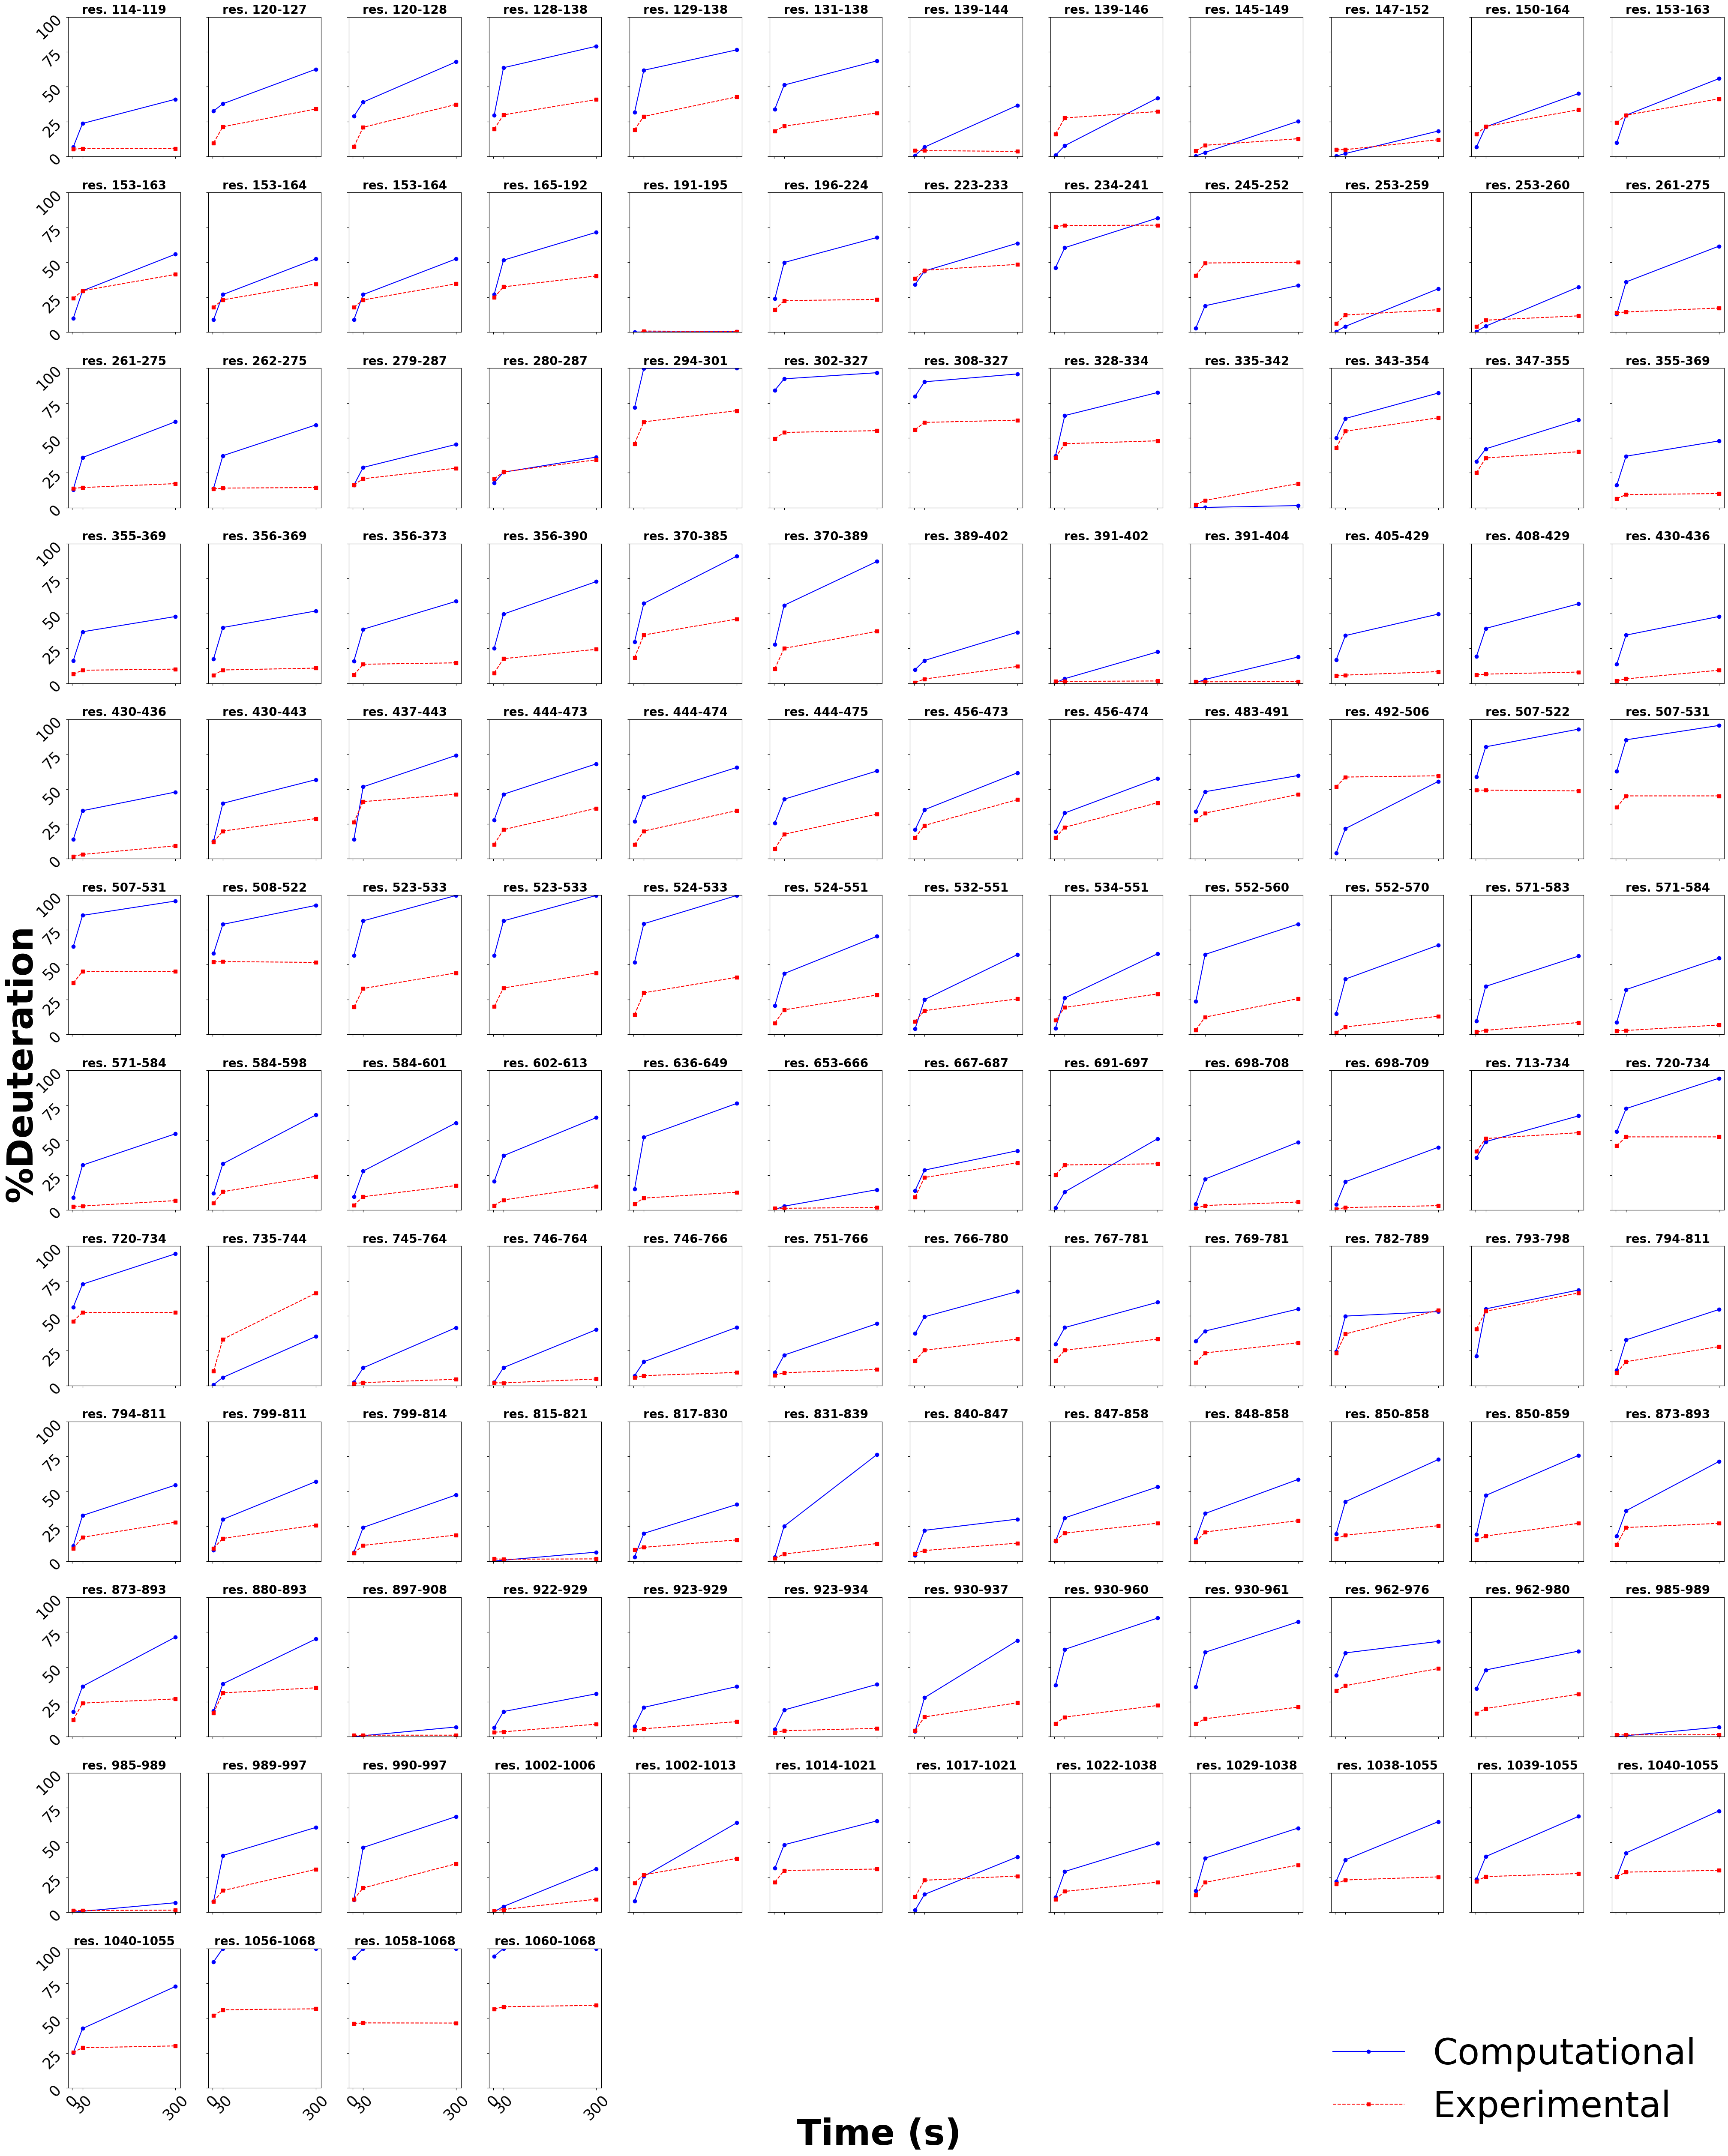

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'comparison'
# Replace this with your actual dataframe if needed
# You can use the following line to read the dataframe from a CSV file:
# comparison = pd.read_csv('your_file.csv')
# Create subplots
num_rows = len(comparison)

fig, axs = plt.subplots(12, 12, figsize=(40, 50), sharex=True, sharey=True)
# Extract relevant columns for plotting
timepoints = [3, 30, 300]
columns_to_plot = ['Comp. %D full, 3s', 'Comp. %D full, 30s', 'Comp. %D full, 300s', 'Exp. %D full, 3s', 'Exp. %D full, 30s', 'Exp. %D full, 300s']
j = -1
c = 0

for i, (index, row) in enumerate(comparison.iterrows()):

        if c!=0 and c<12:

            axs[j, c].plot(timepoints, row[columns_to_plot[:3]], marker='o', linestyle='-',label='Computational', color='blue')
            axs[j, c].plot(timepoints, row[columns_to_plot[3:]], marker='s', linestyle='--',label='Experimental',color='red')
            axs[j, c].set_title(f'res. '+str(int(row['Res1']))+'-'+str(int(row['Res2'])), fontweight='bold', fontsize=20)

            axs[j, c].set_ylim(0,100)
            axs[j, c].tick_params(axis='both', which='major', labelsize=25, rotation=45)
            axs[j, c].set_xticks([0,30, 300])
            
            c += 1
                 
            
        if c==0 or c==12:
            c=0
            j+=1
            axs[j, c].plot(timepoints, row[columns_to_plot[:3]], marker='o', linestyle='-',label='Computational', color='blue')
            axs[j, c].plot(timepoints, row[columns_to_plot[3:]], marker='s', linestyle='--',label='Experimental',color='red')
            axs[j, c].set_title(f'res. '+str(int(row['Res1']))+'-'+str(int(row['Res2'])), fontweight='bold', fontsize=20)
            axs[j, c].set_ylim(0,100)
            axs[j, c].tick_params(axis='both', which='major', labelsize=25, rotation=45)
            axs[j, c].set_xticks([0,30, 300])
            c +=1
            
axs[11, 4].set_visible(False)
axs[11, 5].set_visible(False)
axs[11, 6].set_visible(False)
axs[11, 7].set_visible(False)
axs[11, 8].set_visible(False)
axs[11, 9].set_visible(False)
axs[11, 10].set_visible(False)
axs[11, 11].set_visible(False)
# Add labels to x and y axes of the entire figure
fig.text(0.5, 0, 'Time (s)', ha='center', va='center', fontsize=60, fontweight='bold')
fig.text(0, 0.5, '%Deuteration', ha='center', va='center', rotation='vertical', fontsize=60, fontweight='bold')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize=60,frameon=False)

# Adjust layout and show the plot
plt.tight_layout(pad=2.0)
plt.savefig('full_deuteration_sample.pdf', bbox_inches='tight', dpi=800)
plt.show()

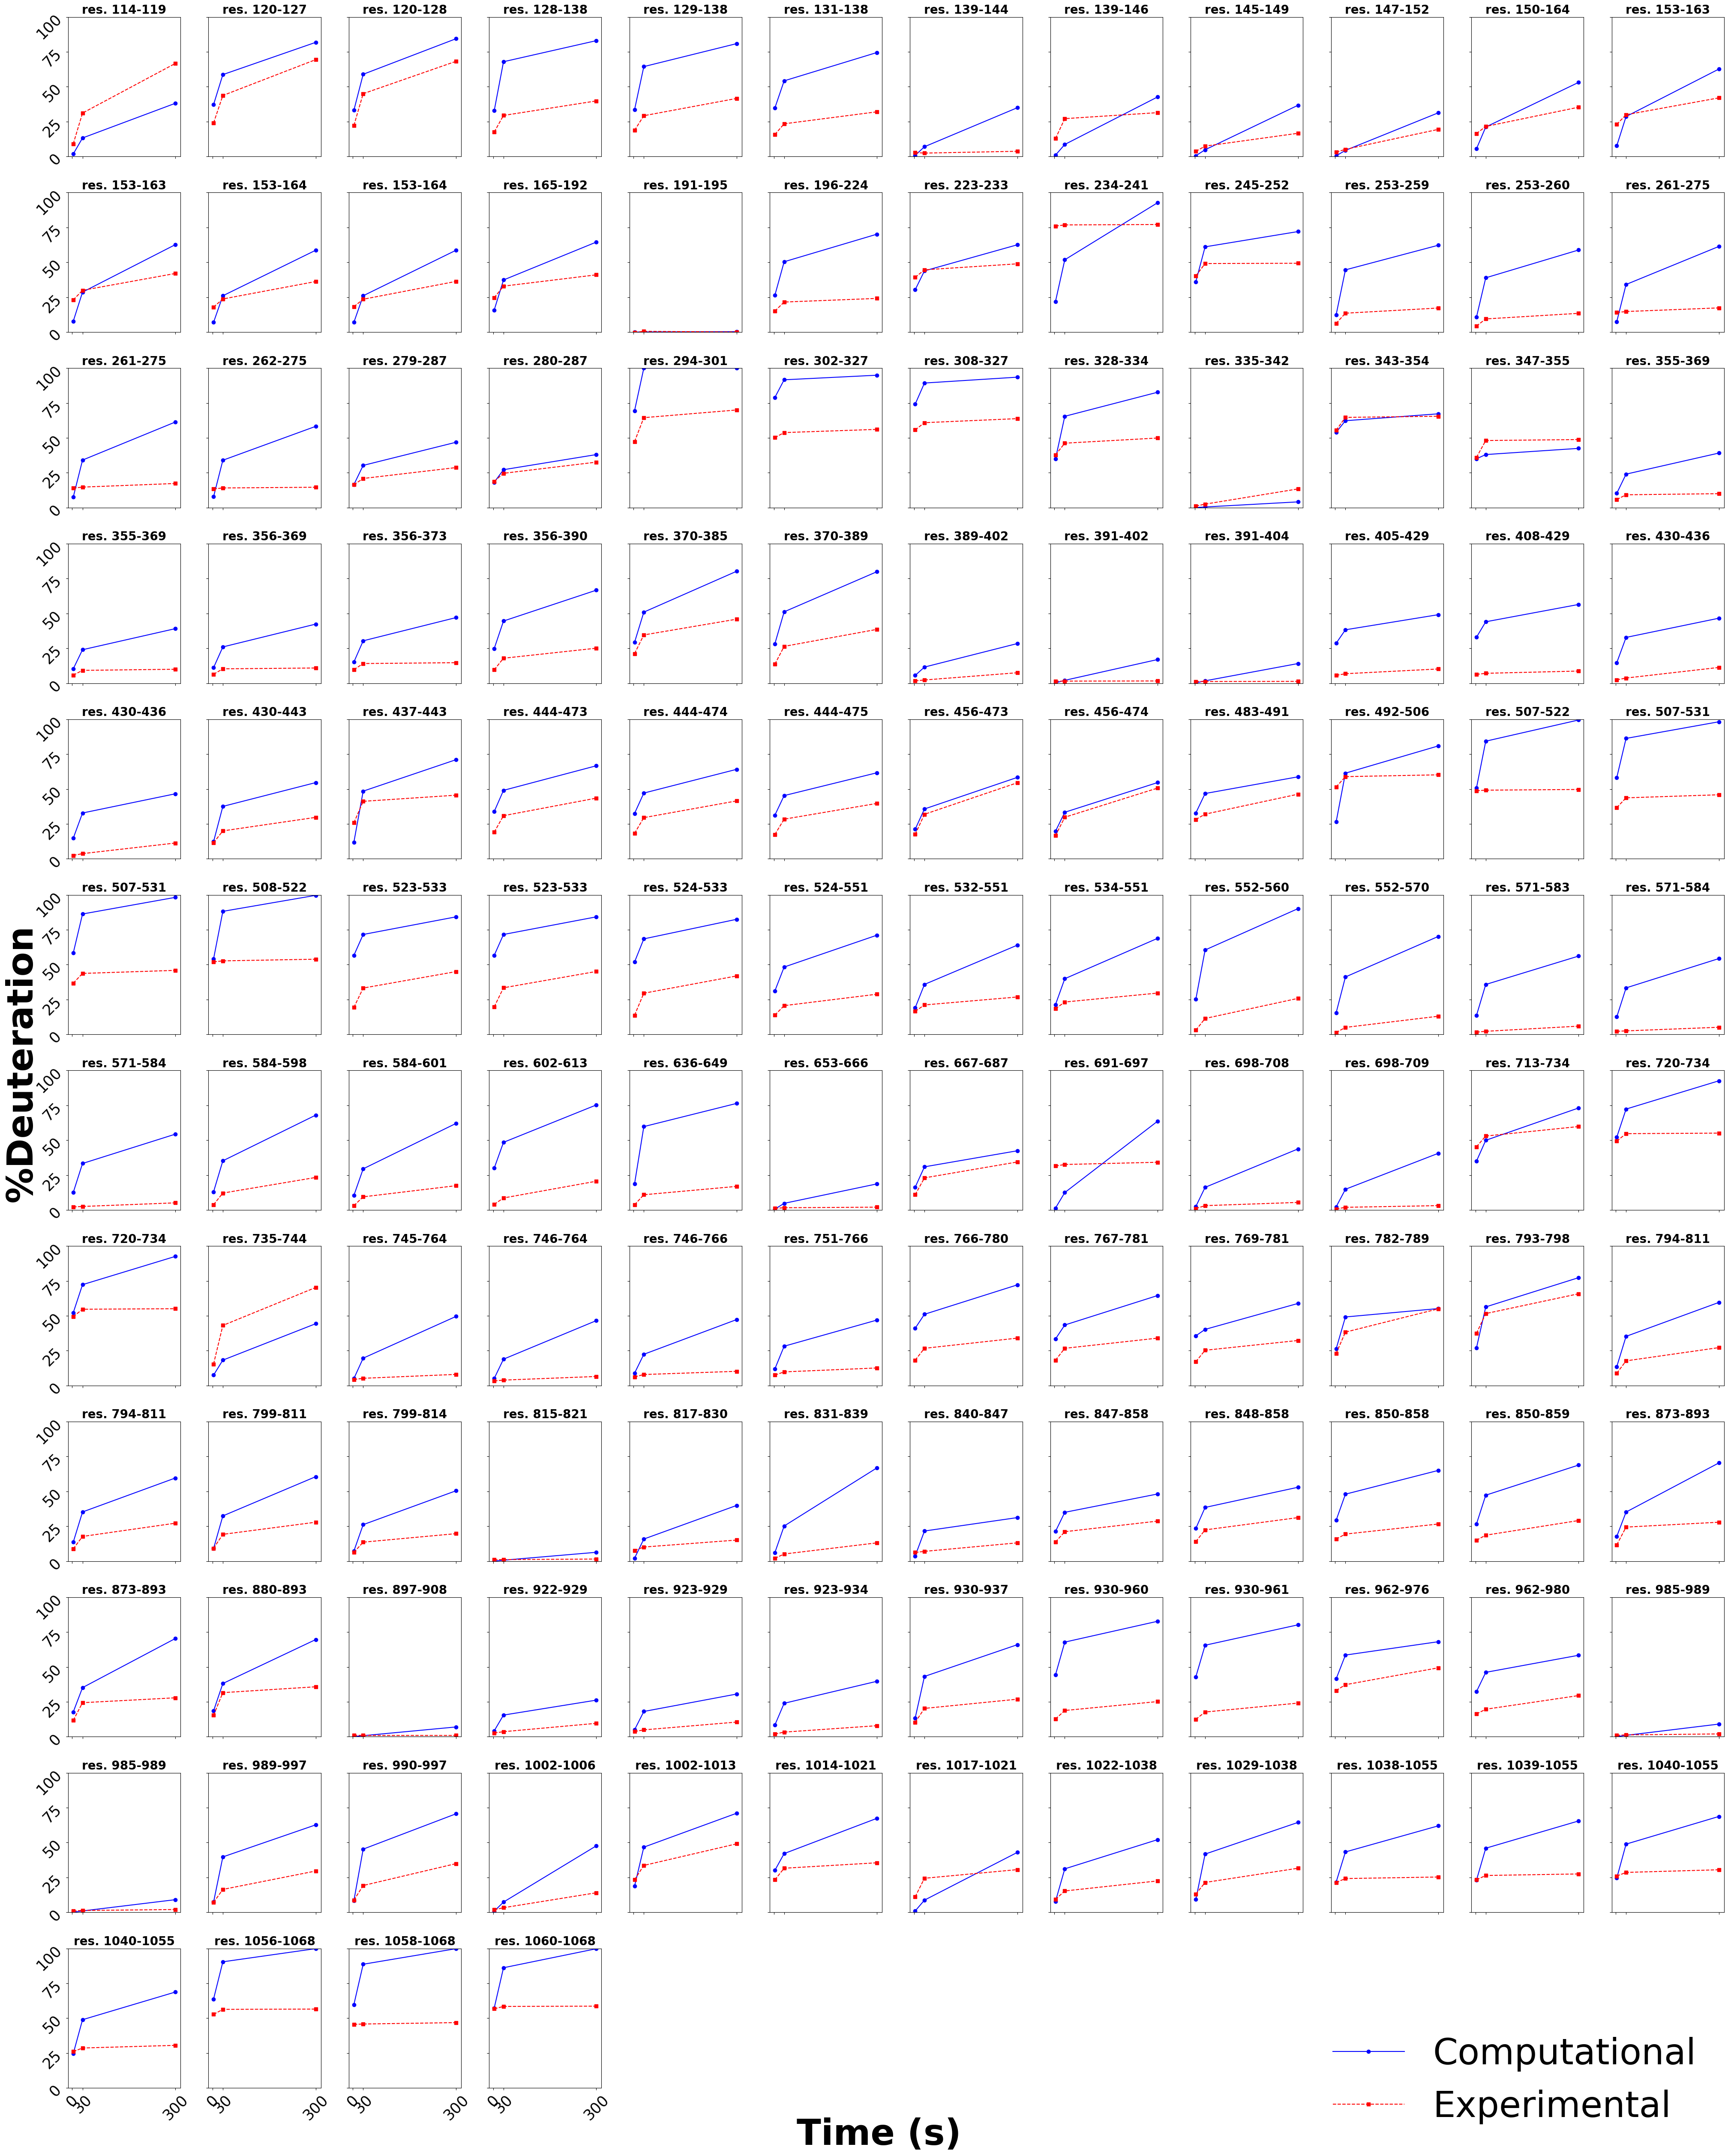

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming your dataframe is named 'comparison'
# Replace this with your actual dataframe if needed
# You can use the following line to read the dataframe from a CSV file:
# comparison = pd.read_csv('your_file.csv')
# Create subplots
num_rows = len(comparison)
fig, axs = plt.subplots(12, 12, figsize=(40, 50),sharex=True, sharey=True)
# Extract relevant columns for plotting
timepoints = [3, 30, 300]
columns_to_plot = ['Comp. %D ΔABD, 3s', 'Comp. %D ΔABD, 30s', 'Comp. %D ΔABD, 300s', 'Exp. %D ΔABD, 3s', 'Exp. %D ΔABD, 30s', 'Exp. %D ΔABD, 300s']
j = -1
c = 0

for i, (index, row) in enumerate(comparison.iterrows()):

        if c!=0 and c<12:

            # Plot for the first subplot
            axs[j, c].plot(timepoints, row[columns_to_plot[:3]], marker='o', linestyle='-',label='Computational', color='blue')
            axs[j, c].plot(timepoints, row[columns_to_plot[3:]], marker='s', linestyle='--',label='Experimental',color='red')
            axs[j, c].set_title(f'res. '+str(int(row['Res1']))+'-'+str(int(row['Res2'])), fontweight='bold', fontsize=20)

            axs[j, c].set_ylim(0,100)
            axs[j, c].tick_params(axis='both', which='major', labelsize=25, rotation=45)
            axs[j, c].set_xticks([0,30, 300])

            c += 1
                 
            
        if c==0 or c==12:
            c=0
            j+=1
            axs[j, c].plot(timepoints, row[columns_to_plot[:3]], marker='o', linestyle='-',label='Computational', color='blue')
            axs[j, c].plot(timepoints, row[columns_to_plot[3:]], marker='s', linestyle='--',label='Experimental',color='red')
            axs[j, c].set_title(f'res. '+str(int(row['Res1']))+'-'+str(int(row['Res2'])), fontweight='bold', fontsize=20)
            axs[j, c].set_ylim(0,100)
            axs[j, c].tick_params(axis='both', which='major', labelsize=25, rotation=45)
            axs[j, c].set_xticks([0,30, 300])
            c +=1
            

            
# Add labels to x and y axes of the entire figure
fig.text(0.5, 0, 'Time (s)', ha='center', va='center', fontsize=60, fontweight='bold')
fig.text(0, 0.5, '%Deuteration', ha='center', va='center', rotation='vertical', fontsize=60, fontweight='bold')

# Add legend for the entire figure
#handles, labels = axs[0, 0].get_legend_handles_labels()
#fig.legend(labels=labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=len(labels), fontsize='large')
axs[11, 4].set_visible(False)
axs[11, 5].set_visible(False)
axs[11, 6].set_visible(False)
axs[11, 7].set_visible(False)
axs[11, 8].set_visible(False)
axs[11, 9].set_visible(False)
axs[11, 10].set_visible(False)
axs[11, 11].set_visible(False)


handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize=60,frameon=False)

# Adjust layout and show the plot
plt.tight_layout(pad=2.0)
plt.savefig('delta_deuteration_sample.pdf', bbox_inches='tight', dpi=800)
plt.show()